# Covid 19 Identification with Chest X Ray


Created By Lalith Kahatapitiya at [PGIS](http://www.pgis.pdn.ac.lk/) - University of Peradeniya

# Data set Credit :
1. [Covid Chest X Ray Dataset](https://github.com/ieee8023/covid-chestxray-dataset)
2. [Pneumonia dataset by Praveen](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset)
3. [COVID19 chest XRAY analysis by SAIMANASA_C](https://www.kaggle.com/code/saimanasachadalavada/covid19-chest-xray-analysis/data)
4. [COVID19 with Pneumonia and Normal Chest Xray(PA) Dataset by AMANULLAH ASRAF](https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset)
5. [HASH_Directors - Covid19 by AMRUTH AMBRISH K](https://www.kaggle.com/code/amruthambrish/hash-directors-covid19/data)
6. [RICORD COVID-19 X-ray positive tests by RADDAR](https://www.kaggle.com/datasets/raddar/ricord-covid19-xray-positive-tests)


# This is the result from each version run on the Kaggle.

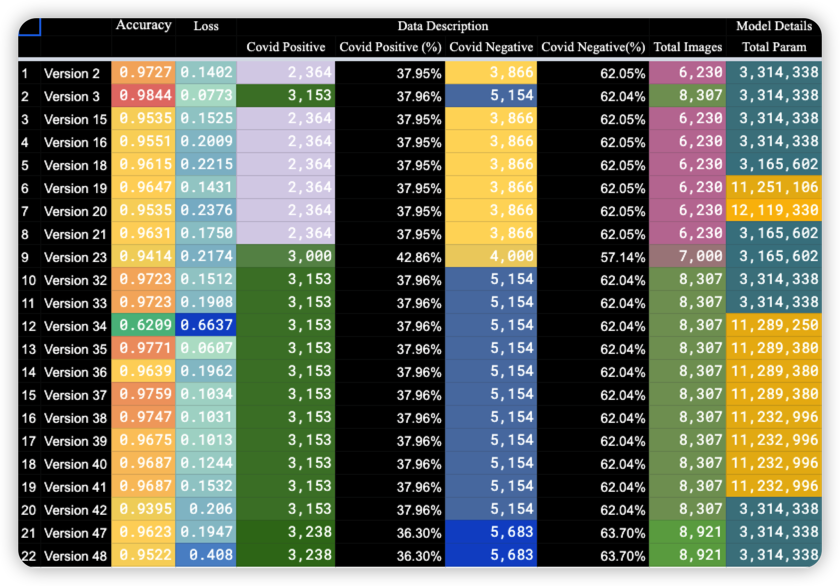


[Datasheet](https://docs.google.com/spreadsheets/d/1wtD3Gx3iLCJO_bs5j1wgDMO9EsDAjMM1aXyK1AUhnHY/edit?usp=sharing)

# System Parameter show




In [1]:
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import cv2
import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import shutil
import random
import sys
import platform
import os
import datetime
import pytz
timezone = pytz.timezone("Asia/Colombo")


print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print()
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
print(f"Open CV {cv2.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


# def working_dir_clean():
#     list_all_file=os.listdir("./")
#     for file_name in list_all_file:
#         try:
#             shutil.rmtree("./"+file_name)
#             print(f"Remove File Name : {file_name}")

#         except Exception as e:
#             print('Exception:',e)
#                     #if any exception rasied, the exception will be printed here. And pass to the next image

# working_dir_clean()

Python Platform: macOS-13.0-arm64-arm-64bit
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0
Pandas 1.5.0
Scikit-Learn 1.1.2
Numpy 1.23.2
Open CV 4.6.0

GPU is available


# Data Set Location Verified and Find Image's Folder

In [2]:
# image data set_path mapping check folder names
dataset_path = 'TRAINING'
# categories = os.listdir(dataset_path)
# print(categories)

# Data Labels creation

In [3]:
categories_all = os.listdir(dataset_path)
categories = []
for category in categories_all:
    if (category == ".DS_Store"):
        continue
    else:
        categories.append(category)

labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))  # empty dictionary


print(label_dict)
print(categories)
print(labels)

{'NORMAL': 0, 'COVID': 1}
['NORMAL', 'COVID']
[0, 1]


# Images count in each folder

In [4]:
# "COVID-19"
folder_path_covid = [
    "TRAINING/COVID",
]


img_path_covid_old = []
for folder_path in folder_path_covid:
    img_names = os.listdir(folder_path)
    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img_path_covid_old.append(img_path)


# "NON-COVID"
folder_path_non_covid = [
    "TRAINING/NORMAL",
]


img_path_non_covid_old = []
for folder_path in folder_path_non_covid:
    img_names = os.listdir(folder_path)
    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img_path_non_covid_old.append(img_path)

        # images array shuffles
img_path_covid_old = random.sample(img_path_covid_old, len(img_path_covid_old))
img_path_non_covid_old = random.sample(
    img_path_non_covid_old, len(img_path_non_covid_old))

total_ca_images = len(img_path_covid_old) + len(img_path_non_covid_old)

print(f"Containe Covid images count     : {len(img_path_covid_old)}")
print(f"Non covid images count : {len(img_path_non_covid_old)}")
print(f"All images count       : {total_ca_images} \n")

#  images array lenth
divider = 1
middle_img_path_covid = int(len(img_path_covid_old)/divider)
middle_img_path_non_covid = int(len(img_path_non_covid_old)/divider)

# middle_img_path_covid = 4099
# middle_img_path_non_covid = middle_img_path_covid

img_path_covid = img_path_covid_old[:middle_img_path_covid]
img_path_non_covid = img_path_non_covid_old[:middle_img_path_non_covid]

total_images = len(img_path_non_covid) + len(img_path_covid)

print(f"Covid images count     : {len(img_path_covid)}")
print(f"Non covid images count : {len(img_path_non_covid)}")
print(f"All images count       : {total_images}")
print(
    f"Covid images           : {round((len(img_path_covid)/total_images)*100, 2)} %")
print(
    f"Non covid images       : {round((len(img_path_non_covid)/total_images)*100, 2)} %")

Containe Covid images count     : 4099
Non covid images count : 5361
All images count       : 9460 

Covid images count     : 4099
Non covid images count : 5361
All images count       : 9460
Covid images           : 43.33 %
Non covid images       : 56.67 %


# Read selected images to array

In [5]:
start_time = datetime.datetime.now(tz=timezone)
print(f"Start images reading :{start_time}")
img_size = 224
data = []
target = []
covid = []
normal = []


def image_read(img_path):
    img = cv2.imread(img_path)
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Coverting the image into gray scale
        resized = cv2.resize(gray, (img_size, img_size))
        # resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
        return True, resized

    except Exception as e:

        # if any exception rasied, the exception will be return here. And pass to the next image
        return False, e


for img_path in img_path_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("non covid images error")
    else:
        covid.append(resized)
        target.append(label_dict["COVID"])


for img_path in img_path_non_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("covid images error")
    else:
        normal.append(resized)
        target.append(label_dict["NORMAL"])


data = covid + normal
end_time = datetime.datetime.now(tz=timezone)
print(f"End images reading :{end_time}")

print(f"Total time taken {end_time-start_time}")

Start images reading :2022-11-03 11:26:50.130710+05:30


libpng warning: cHRM: invalid values


covid images error
End images reading :2022-11-03 11:29:01.465186+05:30
Total time taken 0:02:11.334476


# Normal Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 323.53it/s]


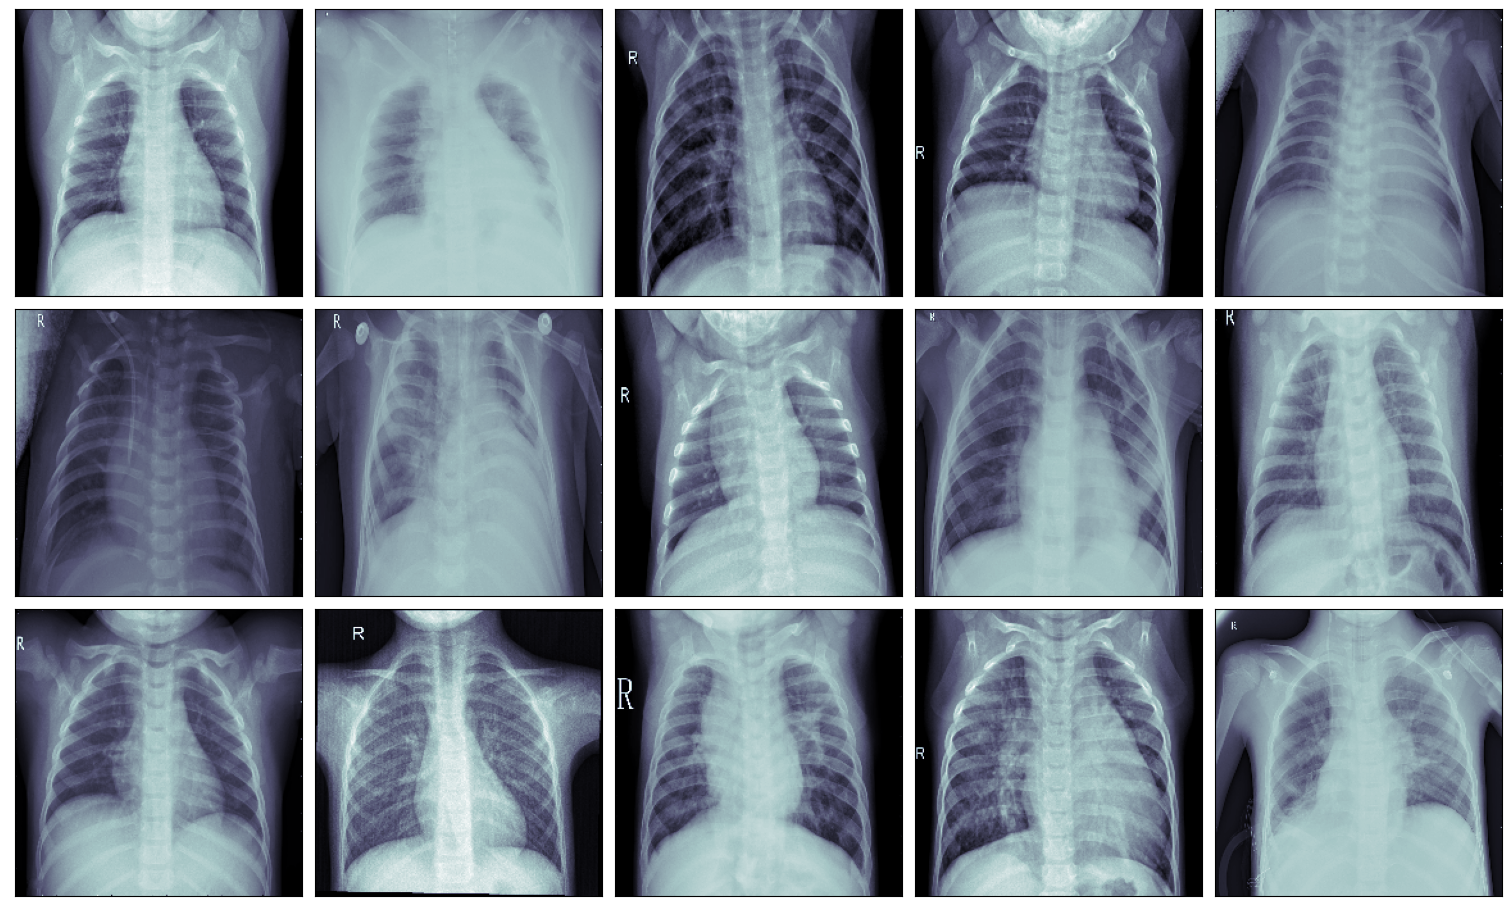

In [6]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize=(
    n_col*3, n_row*3), constrained_layout=True)

for row in tqdm(range(n_row)):

    for col in range(n_col):
        ax[row][col].imshow(normal[row*n_col + col], cmap='bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Covid Positive Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 507.33it/s]


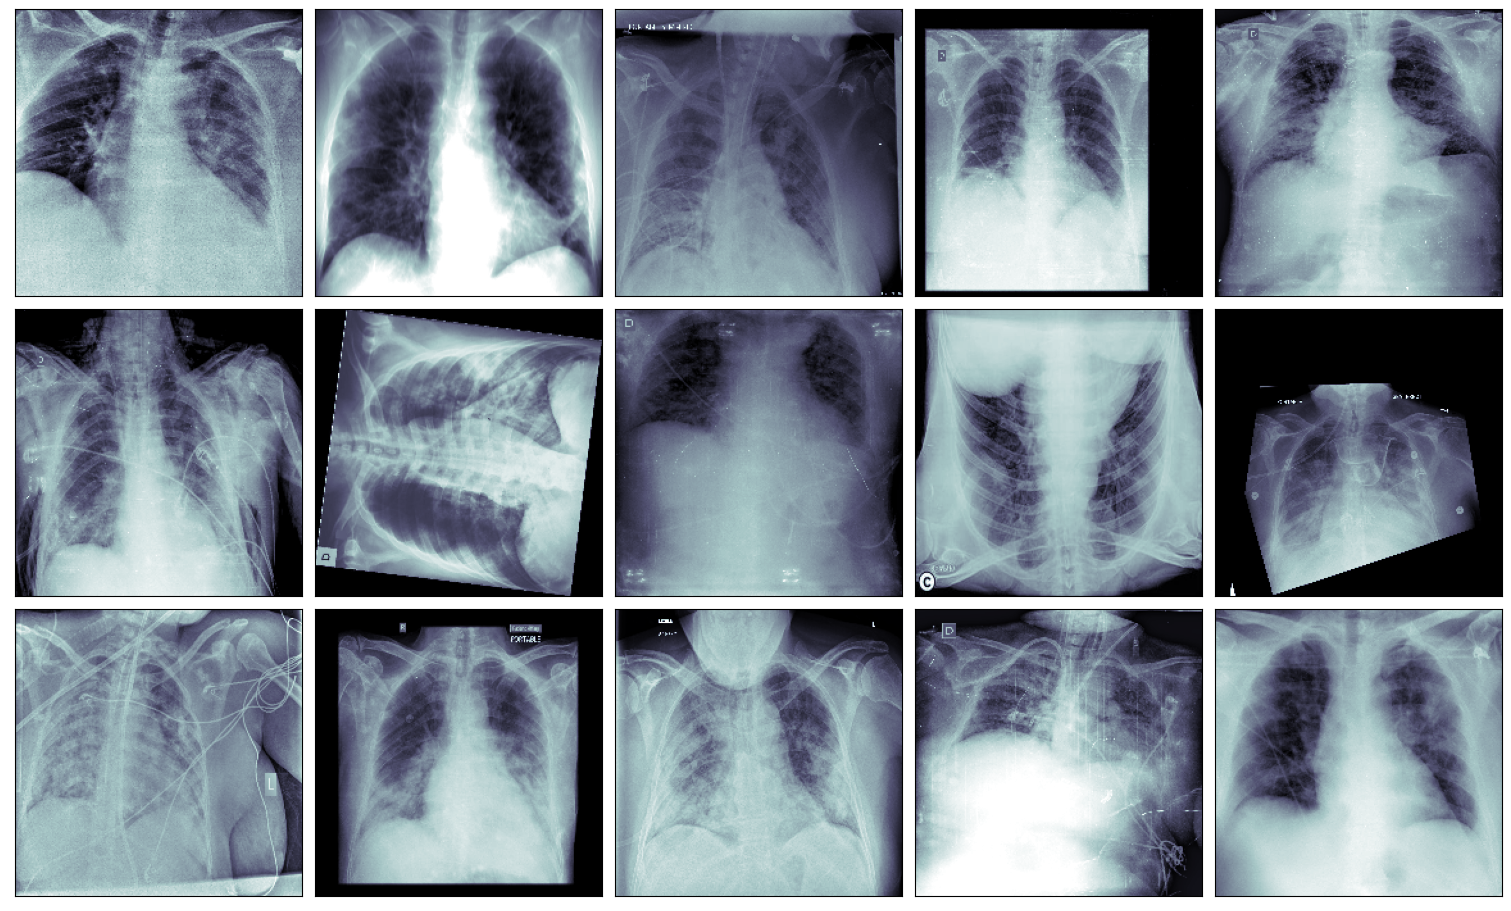

In [7]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize=(
    n_col*3, n_row*3), constrained_layout=True)

for row in tqdm(range(n_row)):

    for col in range(n_col):

        ax[row][col].imshow(covid[row*n_col + col], cmap='bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Wanbd configuration 

In [8]:
from wandb.keras import WandbCallback
import wandb
wandb_api_key = '52c82ac93c7b3a43eab4eee3ee4264af086187eb'
print("W&B: ", wandb.__version__)


start_time = datetime.datetime.now(tz=timezone)
name = f'{start_time}-model-run'
wandb.init(
    project="covid-19-identification-with-chest-x-ray",
    name=name
)
# wandb. init(mode="disabled")

W&B:  0.13.4


wandb: Currently logged in as: lalithk90. Use `wandb login --relogin` to force relogin


# Data array transfer to numpy array and change shape

In [9]:
data = np.array(data)/255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)


new_target = tf.keras.utils.to_categorical(target)


print(
    f"Data shape : {data.shape} \nTarget shape : {target.shape} \nNew Target shape : {new_target.shape}")

Data shape : (9459, 224, 224, 1) 
Target shape : (9459,) 
New Target shape : (9459, 2)


# Model Creation



In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint


input_shape = data.shape[1:]  # 50,50,1
inp = Input(shape=input_shape)
convs = []

parrallel_kernels = [3, 5, 7, 9]

for k in range(len(parrallel_kernels)):
    if (k != 0):
        conv = Conv2D(128, kernel_size=parrallel_kernels[k], padding='same',
                      activation='relu')(inp)

        convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp, out)

model = Sequential()
model.add(conv_model)

# Hidden Layer 1
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Hidden Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Output layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, input_dim=128, activation='sigmoid'))

Metal device set to: Apple M1 Pro


2022-11-03 11:29:12.620536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-03 11:29:12.621075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model Compile

In [11]:
METRICS = [
    'accuracy',
    "sparse_categorical_accuracy",
    'mean_squared_error',
    'mean_absolute_error',
    'mean_absolute_percentage_error',
    'mean_squared_logarithmic_error',
    'cosine_similarity',
    'logcosh',
]

LOSS = 'sparse_categorical_crossentropy'

OPTIMIZER = 'adam'

model.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

# Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 384)     20224     
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      221248    
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                        

# Data Array Spliting

In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.1)

print(type(train_data))
print(
    f"Training Data shape : {train_data.shape} \nTraining Target shape : {train_target.shape}")
print(
    f"Test Data shape : {test_data.shape} \nTest Target shape : {test_target.shape}")

<class 'numpy.ndarray'>
Training Data shape : (8513, 224, 224, 1) 
Training Target shape : (8513,)
Test Data shape : (946, 224, 224, 1) 
Test Target shape : (946,)


# Model Training

In [14]:
start_time = datetime.datetime.now(tz=timezone)
print(f"Start checkpoint creation:{start_time}")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

print(len(train_data))
history = model.fit(train_data,
                    train_target,
                    epochs=25,
                    callbacks=[checkpoint, WandbCallback()],
                    validation_data=(test_data, test_target))

end_time = datetime.datetime.now(tz=timezone)
print(f"End checkpoint creation:{end_time}")
print(f"Total time taken {end_time-start_time}")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Start checkpoint creation:2022-11-03 11:29:16.993699+05:30
8513
Epoch 1/25


2022-11-03 11:29:25.687576: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-03 11:29:26.685594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.8814 - sparse_categorical_accuracy: 0.8814 - mean_squared_error: 0.3637 - mean_absolute_error: 0.4962 - mean_absolute_percentage_error: 218698208.0000 - mean_squared_logarithmic_error: 0.1753 - cosine_similarity: 0.5136 - logcosh: 0.1642

2022-11-03 11:53:36.211301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.96617, saving model to model-001.model


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best)... Done. 0.4s


267/267 [==============================] - 1562s 6s/step - loss: 0.2749 - accuracy: 0.8814 - sparse_categorical_accuracy: 0.8814 - mean_squared_error: 0.3637 - mean_absolute_error: 0.4962 - mean_absolute_percentage_error: 218698208.0000 - mean_squared_logarithmic_error: 0.1753 - cosine_similarity: 0.5136 - logcosh: 0.1642 - val_loss: 0.1065 - val_accuracy: 0.9662 - val_sparse_categorical_accuracy: 0.9662 - val_mean_squared_error: 0.4183 - val_mean_absolute_error: 0.5349 - val_mean_absolute_percentage_error: 276720768.0000 - val_mean_squared_logarithmic_error: 0.1992 - val_cosine_similarity: 0.4802 - val_logcosh: 0.1873
Epoch 2/25
267/267 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9618 - sparse_categorical_accuracy: 0.9618 - mean_squared_error: 0.4087 - mean_absolute_error: 0.5046 - mean_absolute_percentage_error: 232803296.0000 - mean_squared_logarithmic_error: 0.1974 - cosine_similarity: 0.4750 - logcosh: 0.1820
Epoch 2: val_accuracy improved from 0.96617 

INFO:tensorflow:Assets written to: model-002.model/assets


INFO:tensorflow:Assets written to: model-002.model/assets


267/267 [==============================] - 829s 3s/step - loss: 0.1183 - accuracy: 0.9618 - sparse_categorical_accuracy: 0.9618 - mean_squared_error: 0.4087 - mean_absolute_error: 0.5046 - mean_absolute_percentage_error: 232803296.0000 - mean_squared_logarithmic_error: 0.1974 - cosine_similarity: 0.4750 - logcosh: 0.1820 - val_loss: 0.1327 - val_accuracy: 0.9672 - val_sparse_categorical_accuracy: 0.9672 - val_mean_squared_error: 0.3797 - val_mean_absolute_error: 0.5291 - val_mean_absolute_percentage_error: 287288544.0000 - val_mean_squared_logarithmic_error: 0.1856 - val_cosine_similarity: 0.4905 - val_logcosh: 0.1719
Epoch 3/25
267/267 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9689 - sparse_categorical_accuracy: 0.9689 - mean_squared_error: 0.4149 - mean_absolute_error: 0.5061 - mean_absolute_percentage_error: 236856576.0000 - mean_squared_logarithmic_error: 0.2006 - cosine_similarity: 0.4682 - logcosh: 0.1844
Epoch 3: val_accuracy did not improve from 0.

INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best)... Done. 0.4s


267/267 [==============================] - 473s 2s/step - loss: 0.1189 - accuracy: 0.9615 - sparse_categorical_accuracy: 0.9615 - mean_squared_error: 0.4056 - mean_absolute_error: 0.4926 - mean_absolute_percentage_error: 224672320.0000 - mean_squared_logarithmic_error: 0.1961 - cosine_similarity: 0.4707 - logcosh: 0.1801 - val_loss: 0.0773 - val_accuracy: 0.9778 - val_sparse_categorical_accuracy: 0.9778 - val_mean_squared_error: 0.4531 - val_mean_absolute_error: 0.5257 - val_mean_absolute_percentage_error: 282535584.0000 - val_mean_squared_logarithmic_error: 0.2193 - val_cosine_similarity: 0.4393 - val_logcosh: 0.1997
Epoch 6/25
267/267 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9760 - sparse_categorical_accuracy: 0.9760 - mean_squared_error: 0.4254 - mean_absolute_error: 0.5037 - mean_absolute_percentage_error: 221901024.0000 - mean_squared_logarithmic_error: 0.2054 - cosine_similarity: 0.4591 - logcosh: 0.1882
Epoch 6: val_accuracy improved from 0.97780 t

INFO:tensorflow:Assets written to: model-006.model/assets


INFO:tensorflow:Assets written to: model-006.model/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best)... Done. 0.4s


267/267 [==============================] - 478s 2s/step - loss: 0.0770 - accuracy: 0.9760 - sparse_categorical_accuracy: 0.9760 - mean_squared_error: 0.4254 - mean_absolute_error: 0.5037 - mean_absolute_percentage_error: 221901024.0000 - mean_squared_logarithmic_error: 0.2054 - cosine_similarity: 0.4591 - logcosh: 0.1882 - val_loss: 0.0640 - val_accuracy: 0.9831 - val_sparse_categorical_accuracy: 0.9831 - val_mean_squared_error: 0.4552 - val_mean_absolute_error: 0.5289 - val_mean_absolute_percentage_error: 287500928.0000 - val_mean_squared_logarithmic_error: 0.2204 - val_cosine_similarity: 0.4387 - val_logcosh: 0.2005
Epoch 7/25
267/267 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9763 - sparse_categorical_accuracy: 0.9763 - mean_squared_error: 0.4497 - mean_absolute_error: 0.5157 - mean_absolute_percentage_error: 233910192.0000 - mean_squared_logarithmic_error: 0.2171 - cosine_similarity: 0.4513 - logcosh: 0.1982
Epoch 7: val_accuracy did not improve from 0.

INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221103_112906-tysbexhn/files/model-best)... Done. 0.4s


267/267 [==============================] - 490s 2s/step - loss: 0.0381 - accuracy: 0.9873 - sparse_categorical_accuracy: 0.9873 - mean_squared_error: 0.4982 - mean_absolute_error: 0.5587 - mean_absolute_percentage_error: 256152480.0000 - mean_squared_logarithmic_error: 0.2405 - cosine_similarity: 0.4391 - logcosh: 0.2190 - val_loss: 0.0609 - val_accuracy: 0.9831 - val_sparse_categorical_accuracy: 0.9831 - val_mean_squared_error: 0.4878 - val_mean_absolute_error: 0.5555 - val_mean_absolute_percentage_error: 304182432.0000 - val_mean_squared_logarithmic_error: 0.2322 - val_cosine_similarity: 0.4409 - val_logcosh: 0.2139
Epoch 11/25
267/267 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9890 - sparse_categorical_accuracy: 0.9890 - mean_squared_error: 0.4910 - mean_absolute_error: 0.5510 - mean_absolute_percentage_error: 256846432.0000 - mean_squared_logarithmic_error: 0.2373 - cosine_similarity: 0.4398 - logcosh: 0.2159
Epoch 11: val_accuracy improved from 0.98309

INFO:tensorflow:Assets written to: model-011.model/assets


INFO:tensorflow:Assets written to: model-011.model/assets


267/267 [==============================] - 468s 2s/step - loss: 0.0368 - accuracy: 0.9890 - sparse_categorical_accuracy: 0.9890 - mean_squared_error: 0.4910 - mean_absolute_error: 0.5510 - mean_absolute_percentage_error: 256846432.0000 - mean_squared_logarithmic_error: 0.2373 - cosine_similarity: 0.4398 - logcosh: 0.2159 - val_loss: 0.0855 - val_accuracy: 0.9841 - val_sparse_categorical_accuracy: 0.9841 - val_mean_squared_error: 0.4815 - val_mean_absolute_error: 0.5348 - val_mean_absolute_percentage_error: 305515808.0000 - val_mean_squared_logarithmic_error: 0.2338 - val_cosine_similarity: 0.4247 - val_logcosh: 0.2106
Epoch 12/25
267/267 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9890 - sparse_categorical_accuracy: 0.9890 - mean_squared_error: 0.4793 - mean_absolute_error: 0.5371 - mean_absolute_percentage_error: 246185680.0000 - mean_squared_logarithmic_error: 0.2320 - cosine_similarity: 0.4390 - logcosh: 0.2107
Epoch 12: val_accuracy did not improve from 

INFO:tensorflow:Assets written to: model-014.model/assets


INFO:tensorflow:Assets written to: model-014.model/assets


267/267 [==============================] - 467s 2s/step - loss: 0.0272 - accuracy: 0.9906 - sparse_categorical_accuracy: 0.9906 - mean_squared_error: 0.4907 - mean_absolute_error: 0.5433 - mean_absolute_percentage_error: 239695664.0000 - mean_squared_logarithmic_error: 0.2367 - cosine_similarity: 0.4285 - logcosh: 0.2153 - val_loss: 0.0999 - val_accuracy: 0.9873 - val_sparse_categorical_accuracy: 0.9873 - val_mean_squared_error: 0.5167 - val_mean_absolute_error: 0.5878 - val_mean_absolute_percentage_error: 308896480.0000 - val_mean_squared_logarithmic_error: 0.2457 - val_cosine_similarity: 0.4244 - val_logcosh: 0.2265
Epoch 15/25
267/267 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9920 - sparse_categorical_accuracy: 0.9920 - mean_squared_error: 0.5018 - mean_absolute_error: 0.5520 - mean_absolute_percentage_error: 246731984.0000 - mean_squared_logarithmic_error: 0.2427 - cosine_similarity: 0.4244 - logcosh: 0.2200
Epoch 15: val_accuracy did not improve from 

INFO:tensorflow:Assets written to: model-019.model/assets


INFO:tensorflow:Assets written to: model-019.model/assets


267/267 [==============================] - 965s 4s/step - loss: 0.0306 - accuracy: 0.9908 - sparse_categorical_accuracy: 0.9908 - mean_squared_error: 0.5056 - mean_absolute_error: 0.5453 - mean_absolute_percentage_error: 233036448.0000 - mean_squared_logarithmic_error: 0.2428 - cosine_similarity: 0.4204 - logcosh: 0.2213 - val_loss: 0.0625 - val_accuracy: 0.9894 - val_sparse_categorical_accuracy: 0.9894 - val_mean_squared_error: 0.5355 - val_mean_absolute_error: 0.6019 - val_mean_absolute_percentage_error: 300030464.0000 - val_mean_squared_logarithmic_error: 0.2528 - val_cosine_similarity: 0.4304 - val_logcosh: 0.2352
Epoch 20/25
267/267 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9928 - sparse_categorical_accuracy: 0.9928 - mean_squared_error: 0.5066 - mean_absolute_error: 0.5416 - mean_absolute_percentage_error: 225965840.0000 - mean_squared_logarithmic_error: 0.2430 - cosine_similarity: 0.4086 - logcosh: 0.2215
Epoch 20: val_accuracy did not improve from 

INFO:tensorflow:Assets written to: model-022.model/assets


INFO:tensorflow:Assets written to: model-022.model/assets


267/267 [==============================] - 409s 2s/step - loss: 0.0133 - accuracy: 0.9948 - sparse_categorical_accuracy: 0.9948 - mean_squared_error: 0.5193 - mean_absolute_error: 0.5502 - mean_absolute_percentage_error: 219622576.0000 - mean_squared_logarithmic_error: 0.2490 - cosine_similarity: 0.3972 - logcosh: 0.2268 - val_loss: 0.0754 - val_accuracy: 0.9905 - val_sparse_categorical_accuracy: 0.9905 - val_mean_squared_error: 0.5830 - val_mean_absolute_error: 0.6248 - val_mean_absolute_percentage_error: 287647776.0000 - val_mean_squared_logarithmic_error: 0.2745 - val_cosine_similarity: 0.4227 - val_logcosh: 0.2553
Epoch 23/25
267/267 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9918 - sparse_categorical_accuracy: 0.9918 - mean_squared_error: 0.5171 - mean_absolute_error: 0.5515 - mean_absolute_percentage_error: 218328720.0000 - mean_squared_logarithmic_error: 0.2481 - cosine_similarity: 0.3952 - logcosh: 0.2261
Epoch 23: val_accuracy did not improve from 

# Model Save

In [15]:
model.save('model-v3.h5')

In [77]:
for idx in range(len(model.layers)):
    print(f'Name : {model.get_layer(index=idx).name}, Shape :  {model.get_layer(index=idx).output_shape}')

Name : model, Shape :  (None, 224, 224, 384)
Name : conv2d_3, Shape :  (None, 222, 222, 64)
Name : activation, Shape :  (None, 222, 222, 64)
Name : max_pooling2d, Shape :  (None, 111, 111, 64)
Name : conv2d_4, Shape :  (None, 109, 109, 32)
Name : activation_1, Shape :  (None, 109, 109, 32)
Name : max_pooling2d_1, Shape :  (None, 54, 54, 32)
Name : flatten, Shape :  (None, 93312)
Name : dropout, Shape :  (None, 93312)
Name : dense, Shape :  (None, 128)
Name : dropout_1, Shape :  (None, 128)
Name : dense_1, Shape :  (None, 64)
Name : dropout_2, Shape :  (None, 64)
Name : dense_2, Shape :  (None, 32)
Name : dropout_3, Shape :  (None, 32)
Name : dense_3, Shape :  (None, 2)


# Plot model to png

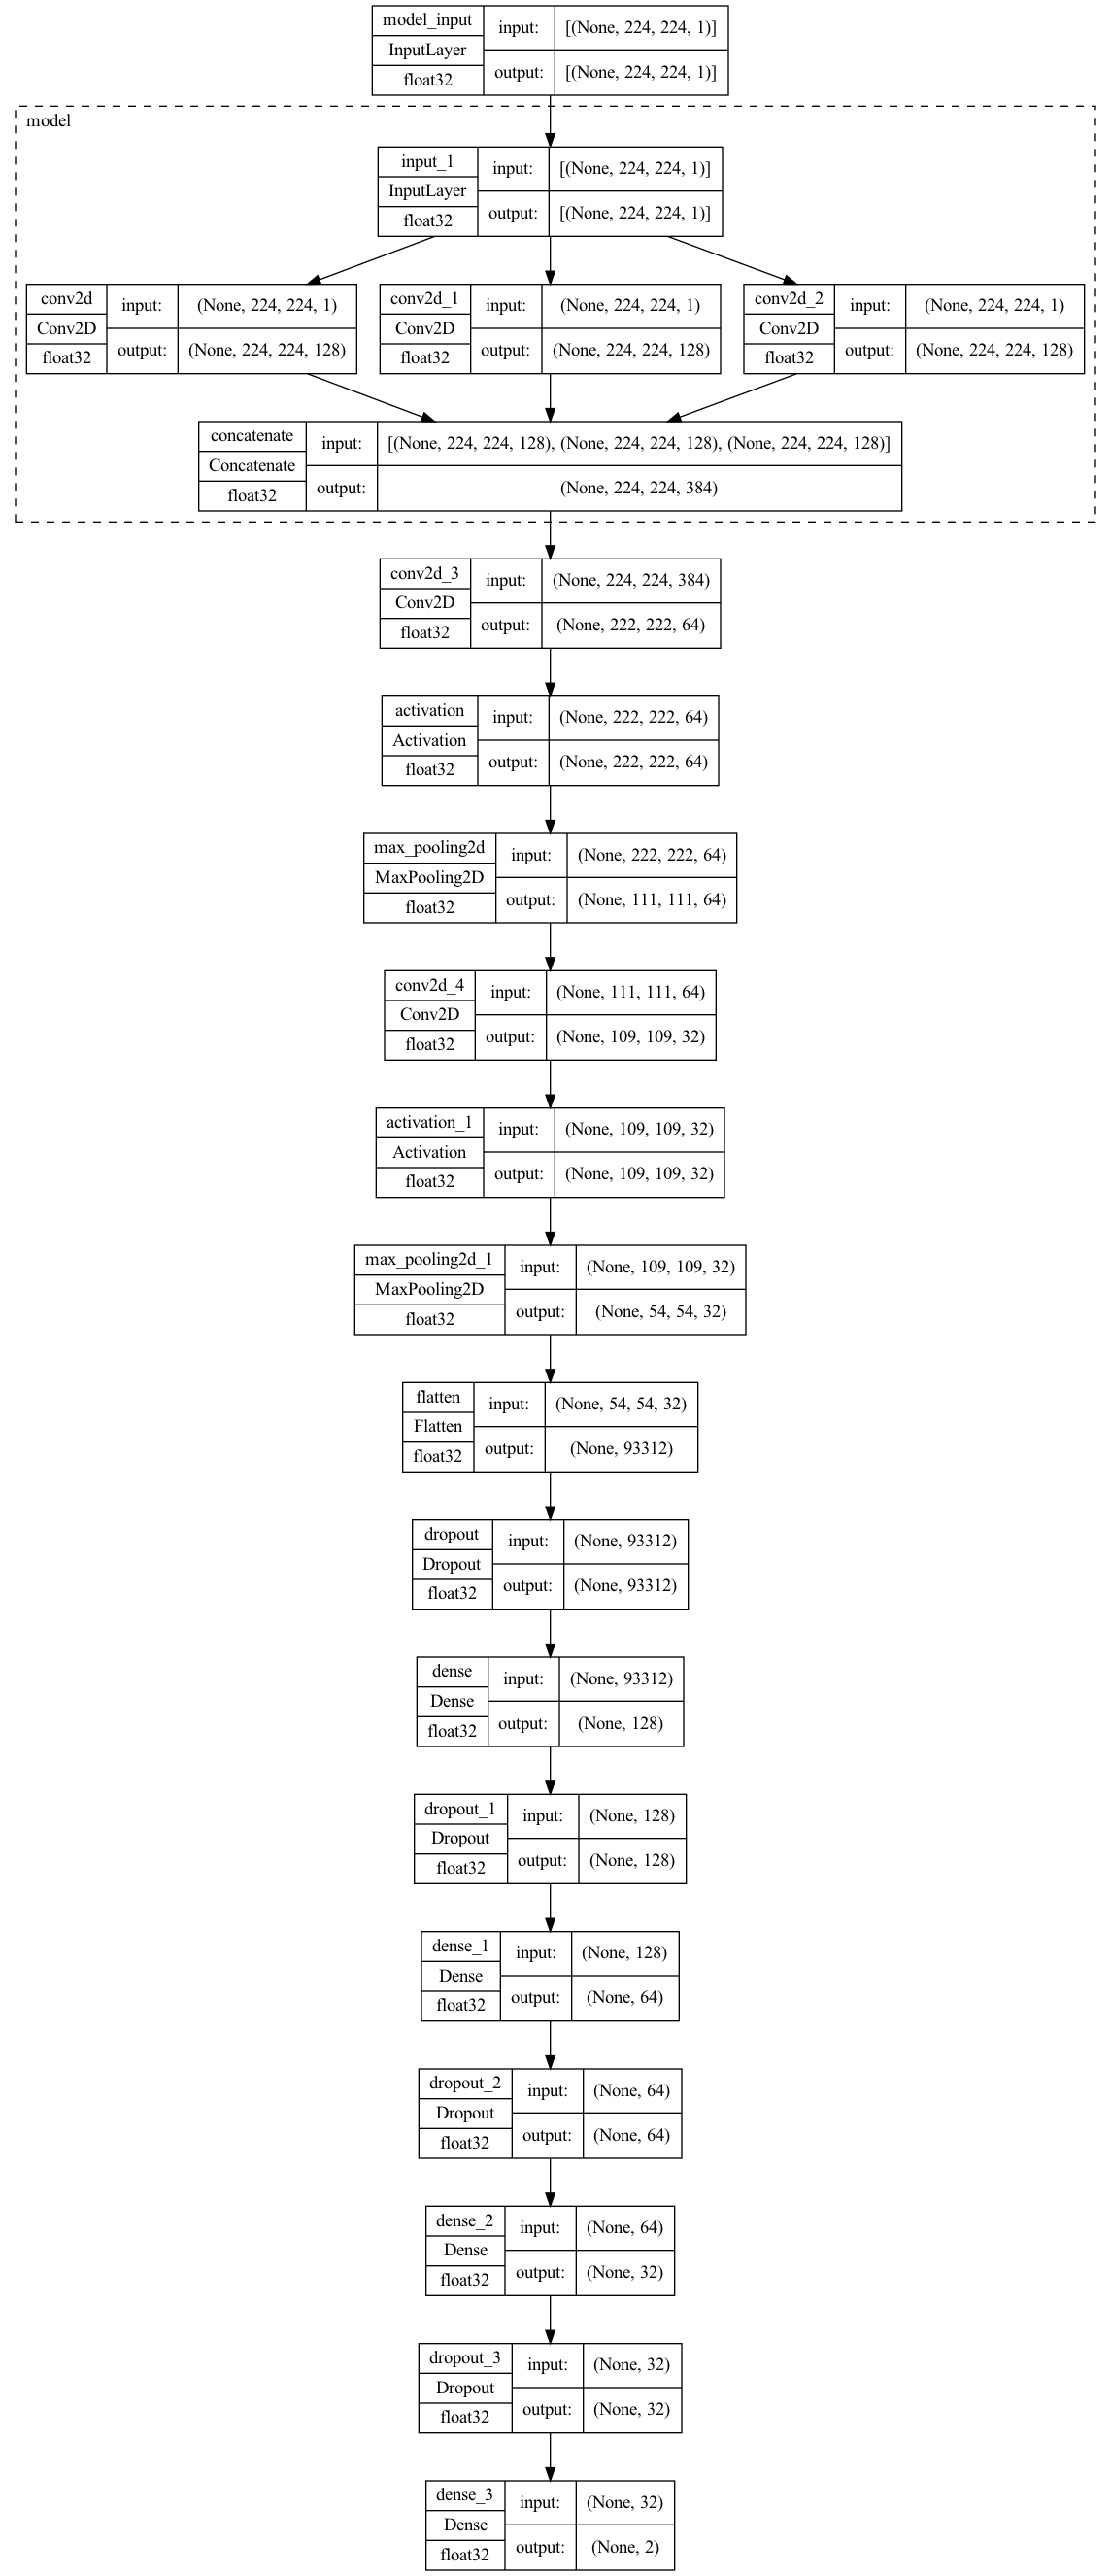

In [17]:
# plot model as image
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
)

In [18]:
# date labeling confusion was removed

X_train = train_data
Y_train = train_target

x_test = test_data
y_test = test_target

# Valued to plot in epochs traing's history

## Training and validation accuracy Model

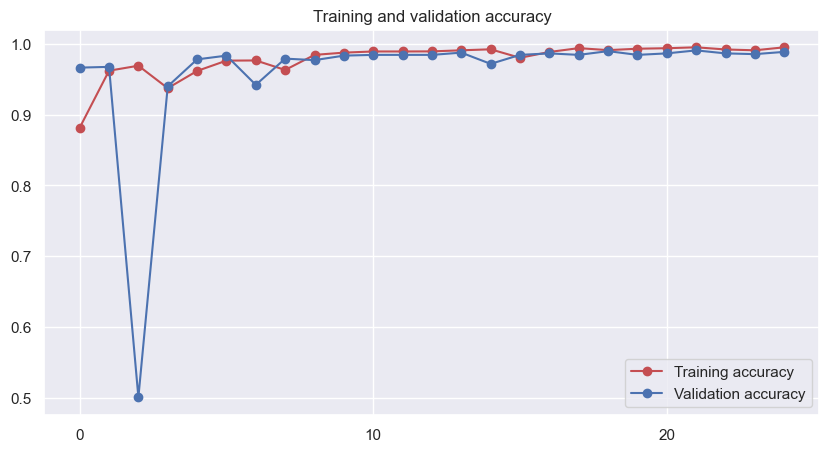

<Figure size 640x480 with 0 Axes>

In [19]:
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0, len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy', marker="o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker="o")
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

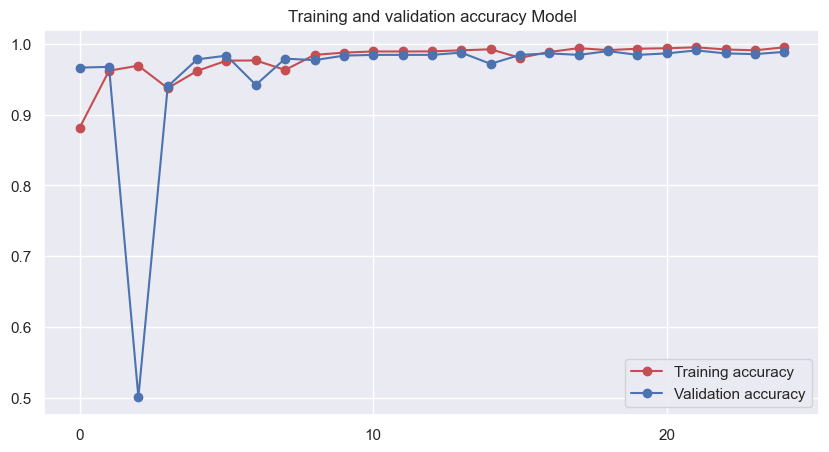

<Figure size 640x480 with 0 Axes>

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()
plt.show()

## Training and validation Loss Model

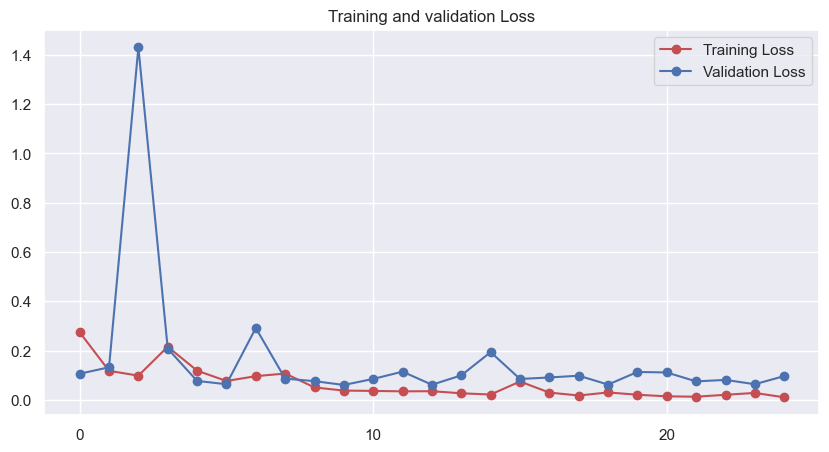

<Figure size 640x480 with 0 Axes>

In [21]:
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0, len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

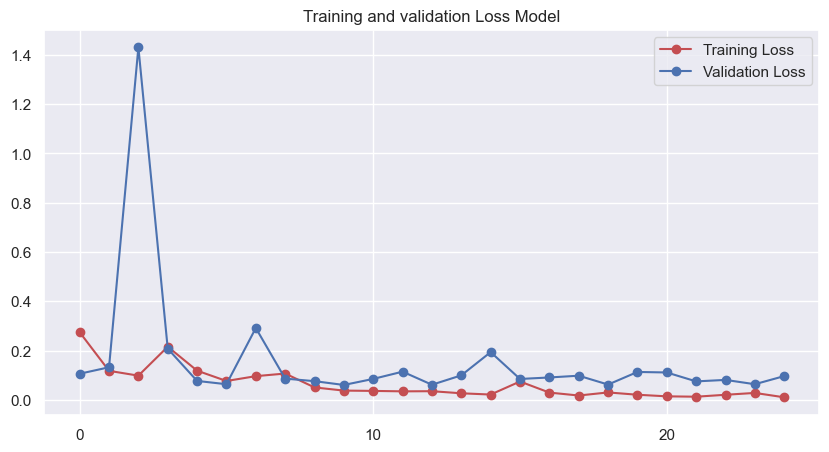

<Figure size 640x480 with 0 Axes>

In [22]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['loss']
val_loss = history.history['val_loss']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Sparse categorical accuracy Model

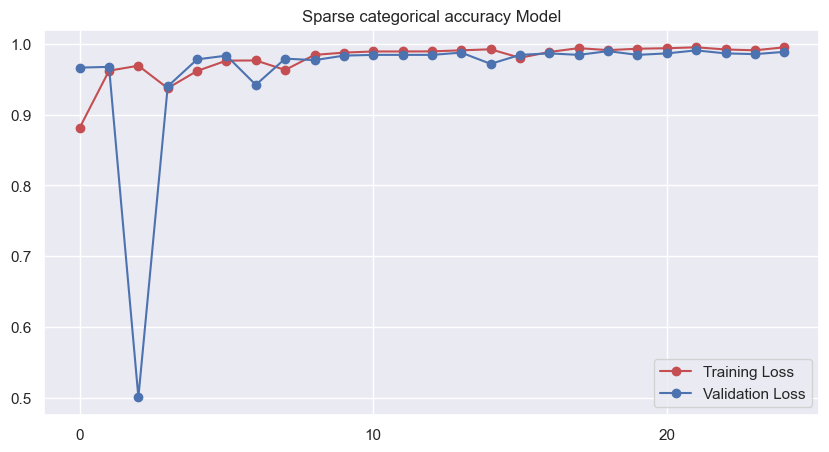

<Figure size 640x480 with 0 Axes>

In [23]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_sparse_categorical_accuracy']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Sparse categorical accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared error in model

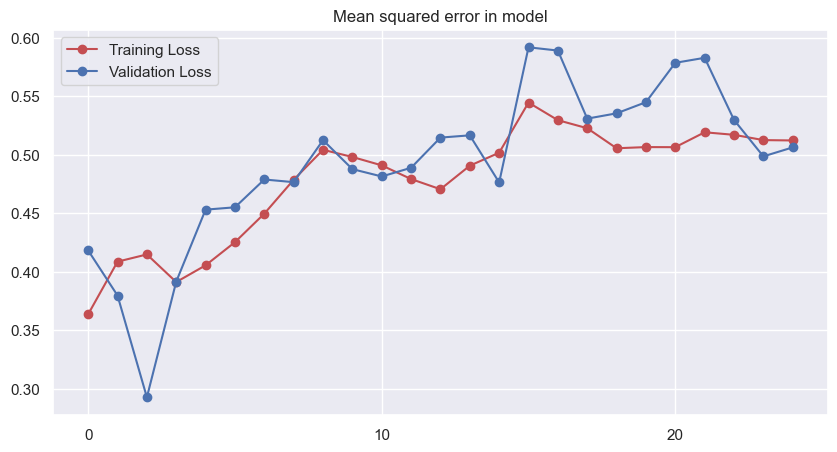

<Figure size 640x480 with 0 Axes>

In [24]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared absolute error in model

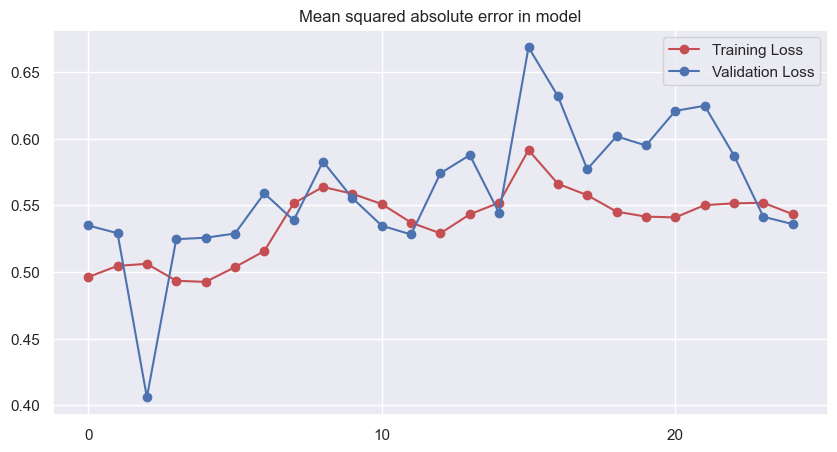

<Figure size 640x480 with 0 Axes>

In [25]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared absolute error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean absolute percentage error in model

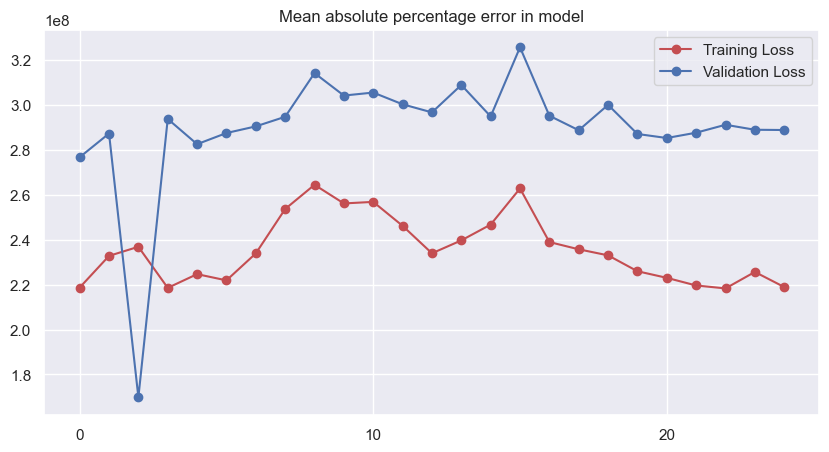

<Figure size 640x480 with 0 Axes>

In [26]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_absolute_percentage_error']
val_loss = history.history['val_mean_absolute_percentage_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean absolute percentage error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared logarithmic error in model

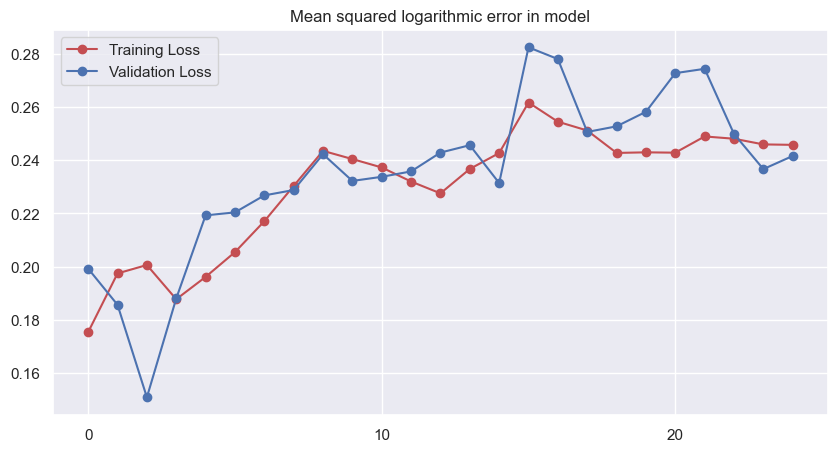

<Figure size 640x480 with 0 Axes>

In [27]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_squared_logarithmic_error']
val_loss = history.history['val_mean_squared_logarithmic_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared logarithmic error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Cosine similarity in model

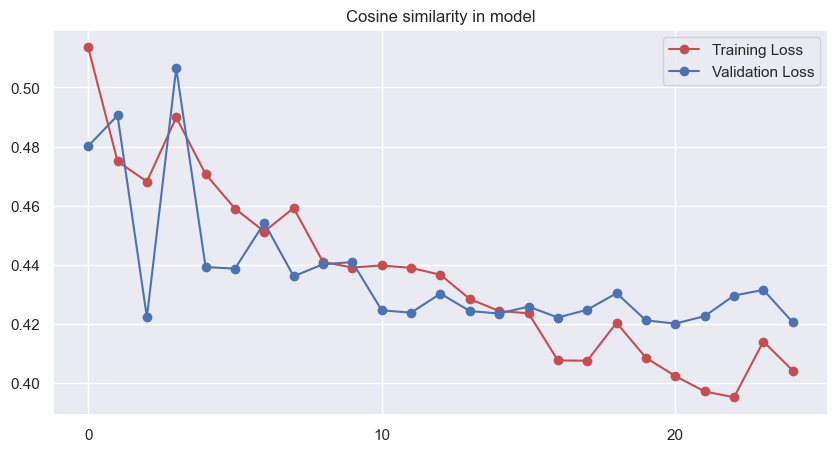

<Figure size 640x480 with 0 Axes>

In [28]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['cosine_similarity']
val_loss = history.history['val_cosine_similarity']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Cosine similarity in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Log-Cosh Loss

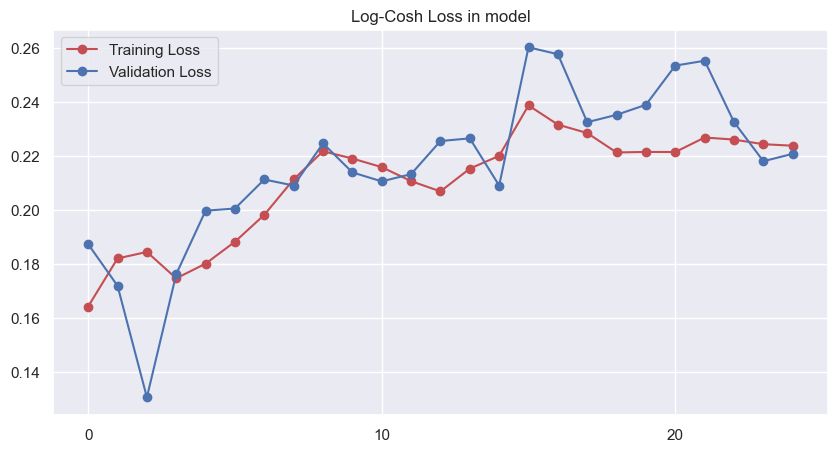

<Figure size 640x480 with 0 Axes>

In [29]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['logcosh']
val_loss = history.history['val_logcosh']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Log-Cosh Loss in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

# Model Evaluation 

## Model Evaluation Results

In [30]:
score = model.evaluate(test_data,test_target)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 18s 585ms/step - loss: 0.0969 - accuracy: 0.9884 - sparse_categorical_accuracy: 0.9884 - mean_squared_error: 0.5064 - mean_absolute_error: 0.5359 - mean_absolute_percentage_error: 288841184.0000 - mean_squared_logarithmic_error: 0.2416 - cosine_similarity: 0.4206 - logcosh: 0.2208

Test loss: 0.09693323075771332
Test accuracy: 0.9883720874786377


## Confution Matrix

 1/30 [>.............................] - ETA: 9s

2022-11-03 15:14:01.309807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 17s 581ms/step


<Figure size 1000x500 with 0 Axes>

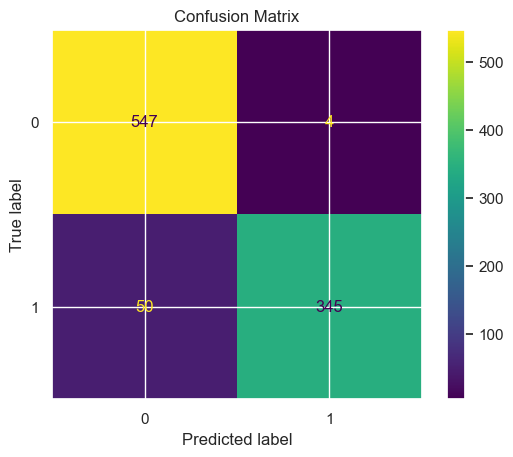

<Figure size 640x480 with 0 Axes>

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

fig = plt.gcf()
fig.set_size_inches(10, 5)

clf = model
pred = model.predict(x_test)[:, 1]
# print(pred)
predictions = (pred > 0.5).astype(int)
# print(predictions)
# print(y_test)
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.figure()
plt.show()

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(f'TN : {tn}, \nFP : {fp}, \nFN : {fn}, \nTP : {tp}')

TN : 547, 
FP : 4, 
FN : 50, 
TP : 345


## Sensitivity / True Positive Rate

In [33]:
# Sensitivity = True Positives/ (True Positives + True Negatives)
sensitivity = tp / (tp + tn)
print(f"Sensitivity : {sensitivity}")

Sensitivity : 0.3867713004484305


## Specificity / True Negative Rate:

In [34]:
# Specificity = True Negatives/ (False Positives + True Negatives)
specificity = tn / (fp+tn)
print(f"Specificity : {specificity}")

Specificity : 0.9927404718693285


## ROC AUC Score

In [35]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, predictions)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.9331


## ROC Curve

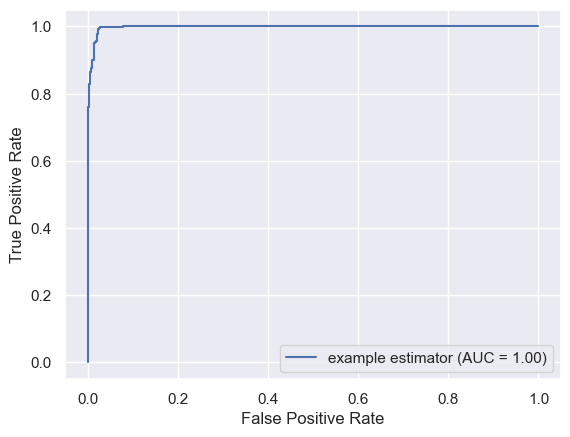

In [36]:
import matplotlib.pyplot as plt

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
#plt.savefig('Multiclass Model .png')
plt.show()

##  Classification Report

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       551
           1       0.99      0.87      0.93       395

    accuracy                           0.94       946
   macro avg       0.95      0.93      0.94       946
weighted avg       0.95      0.94      0.94       946



/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2148: UserWarning: labels size, 10, does not match size of target_names, 9
  warnings.warn(
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.p

<AxesSubplot: >

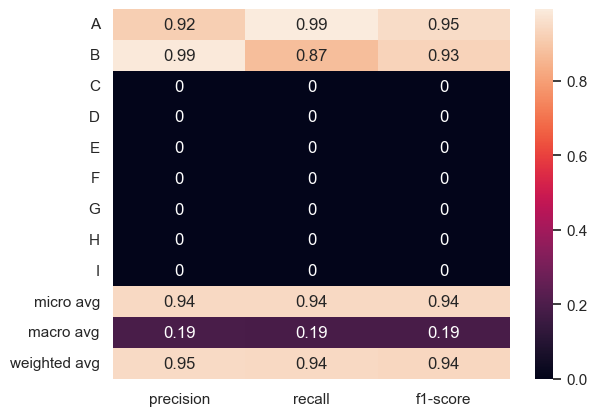

In [37]:
from sklearn.metrics import classification_report
import seaborn as sns
target_names = list("ABCDEFGHI")
labels = np.arange(10)

classification_report_1 = classification_report(y_test, predictions)
print(classification_report_1)
classification_report = classification_report(y_test, predictions, labels=labels,
                                              target_names=target_names,
                                              output_dict=True)

sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)

## Accuracy Score

In [38]:
from sklearn.metrics import accuracy_score
y_pred = predictions
y_true = y_test

ac_s_without_normalize = accuracy_score(y_true, y_pred)
print(f"Accuracy score without normalize : {ac_s_without_normalize}")

ac_s_with_normalize = accuracy_score(y_true, y_pred, normalize=False)
print(f"Accuracy score with normalize: {ac_s_with_normalize}")

Accuracy score without normalize : 0.9429175475687104
Accuracy score with normalize: 892


## Balance Accuracy Score

In [39]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced accuracy score : {balanced_accuracy_score}")

Balanced accuracy score : 0.9330790966941579


## Average precision score

In [40]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score(y_true, y_pred)
print(f"Average precision score : {average_precision_score}")

Average precision score : 0.91626132584234


## Precision Score

Precision score macro : 0.9523932940730395
Precision score micro : 0.9429175475687104
Precision score weighted : 0.9464327438525744
Precision score : [0.91624791 0.98853868]


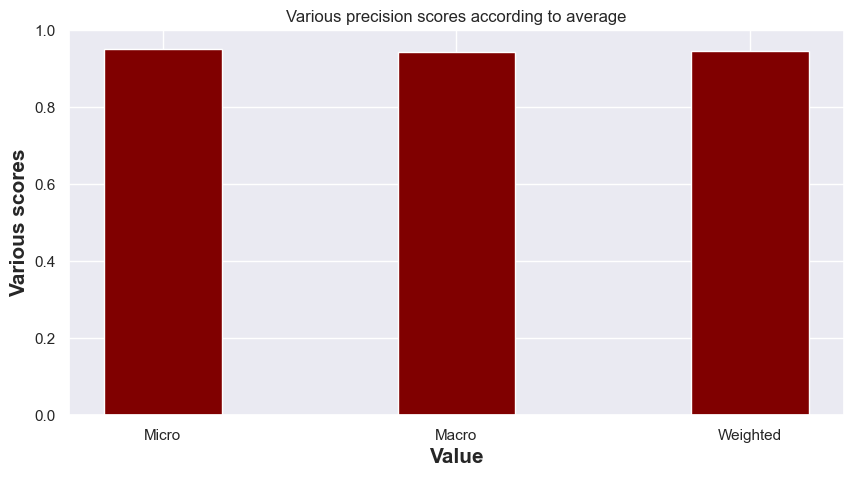

In [41]:
from sklearn.metrics import precision_score

precision_score_macro = precision_score(y_true, y_pred, average='macro')

precision_score_micro = precision_score(y_true, y_pred, average='micro')

precision_score_weighted = precision_score(y_true, y_pred, average='weighted')

precision_score = precision_score(y_true, y_pred, average=None)

print(f"Precision score macro : {precision_score_macro}")
print(f"Precision score micro : {precision_score_micro}")
print(f"Precision score weighted : {precision_score_weighted}")
print(f"Precision score : {precision_score}")


data = {'Micro': precision_score_macro, 'Macro': precision_score_micro,
        'Weighted': precision_score_weighted}
values = list(data.keys())
results = list(data.values())

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(values, results, color='maroon',
        width=0.4)

plt.xlabel('Value', fontweight='bold', fontsize=15)
plt.ylabel('Various scores', fontweight='bold', fontsize=15)
plt.title("Various precision scores according to average")
#plt.savefig('Multiclass Model .png')
plt.show()

## Recall Score

Recall score macro : 0.9330790966941579
Recall score micro : 0.9429175475687104
Recall score weighted : 0.9429175475687104
Recall score : [0.99274047 0.87341772]


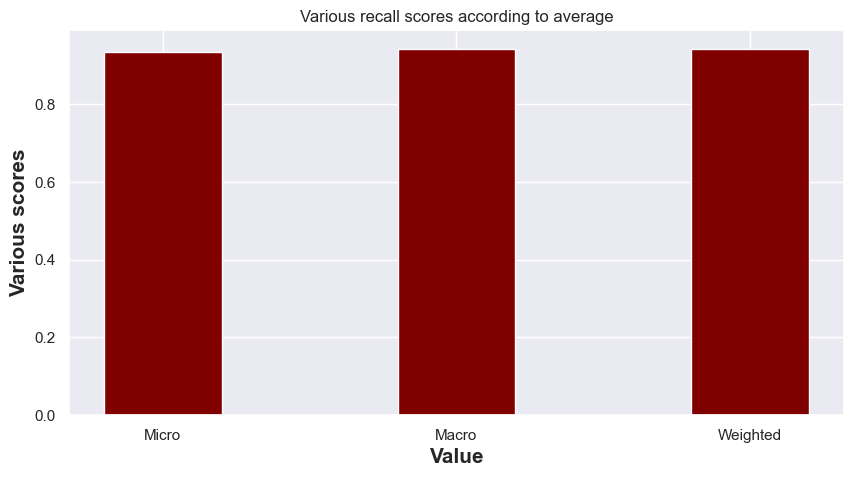

In [42]:
from sklearn.metrics import recall_score

recall_score_macro = recall_score(y_true, y_pred, average='macro')

recall_score_micro = recall_score(y_true, y_pred, average='micro')

recall_score_weighted = recall_score(y_true, y_pred, average='weighted')

recall_score = recall_score(y_true, y_pred, average=None)


print(f"Recall score macro : {recall_score_macro}")
print(f"Recall score micro : {recall_score_micro}")
print(f"Recall score weighted : {recall_score_weighted}")
print(f"Recall score : {recall_score}")

data = {'Micro': recall_score_macro, 'Macro': recall_score_micro,
        'Weighted': recall_score_weighted}
values = list(data.keys())
results = list(data.values())

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(values, results, color='maroon',
        width=0.4)

plt.xlabel('Value', fontweight='bold', fontsize=15)
plt.ylabel('Various scores', fontweight='bold', fontsize=15)
plt.title("Various recall scores according to average")
#plt.savefig('Multiclass Model .png')
plt.show()

## F1 Score

Recall score macro : 0.9401905136562887
Recall score micro : 0.9429175475687104
Recall score weighted : 0.9422965398460796
Recall score : [0.95296167 0.92741935]


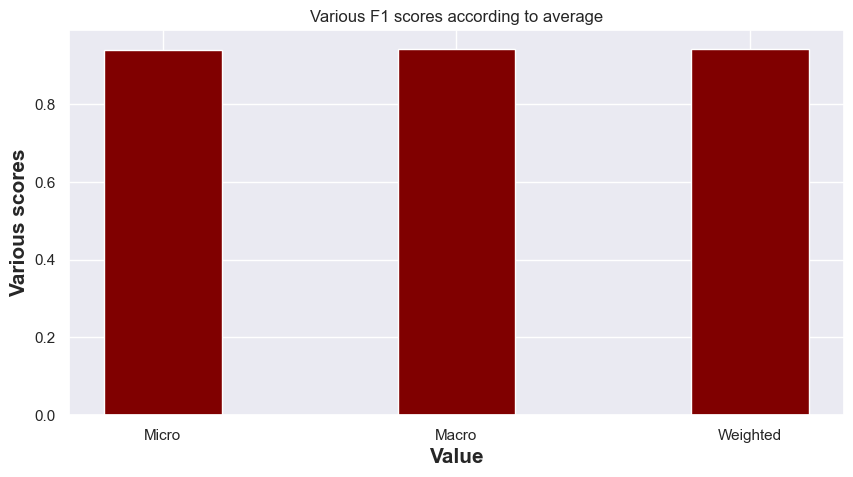

In [43]:
from sklearn.metrics import f1_score

f1_score_macro = f1_score(y_true, y_pred, average='macro')

f1_score_micro = f1_score(y_true, y_pred, average='micro')

f1_score_weighted = f1_score(y_true, y_pred, average='weighted')

f1_score = f1_score(y_true, y_pred, average=None)

print(f"Recall score macro : {f1_score_macro}")
print(f"Recall score micro : {f1_score_micro}")
print(f"Recall score weighted : {f1_score_weighted}")
print(f"Recall score : {f1_score}")

data = {'Micro': f1_score_macro, 'Macro': f1_score_micro,
        'Weighted': f1_score_weighted}
values = list(data.keys())
results = list(data.values())

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(values, results, color='maroon',
        width=0.4)

plt.xlabel('Value', fontweight='bold', fontsize=15)
plt.ylabel('Various scores', fontweight='bold', fontsize=15)
plt.title("Various F1 scores according to average")
#plt.savefig('Multiclass Model .png')
plt.show()

## Binary accuracy

In [44]:
m = tf.keras.metrics.binary_accuracy(y_true, y_pred)
print(f"Binary accuracy: {m}")

Binary accuracy: 0.94291752576828


## Categorical accuracy

In [80]:
m = tf.keras.metrics.categorical_accuracy(y_true, y_pred)
print(f"Categorical accuracy: {m}")

Categorical accuracy: 1.0


# Grad-CAM and Saliency Map 


In [83]:
import matplotlib.cm as cm

from IPython.display import Image, display

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf

import numpy as np
import imutils
import cv2

In [68]:
# this function is udes to generate the heat map of aan image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [69]:

def get_img_array(img_path):
    img = cv2.imread(img_path)
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Coverting the image into gray scale
        resized = cv2.resize(gray, (img_size, img_size))
        # resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
        return resized

    except Exception as e:

        # if any exception rasied, the exception will be return here. And pass to the next image
        return  e

### save and display gradcam

In [70]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    img input shoud not be expanded 
    """

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### Image prediction and visualization

In [78]:
# function that is used to predict the image type and the ares that are affected by covid


def image_prediction_and_visualization(path,last_conv_layer_name = "conv2d_4", model = model):
#   input:  is the image path, name of last convolution layer , model name
#   output : returs the predictions and the area that is effected

  
    img_array = get_img_array(path)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    plt.title("the heat map of the image is ")
    plt.imshow(heatmap)
    plt.show()
    print()
    img = get_img_array(path)
    res = class_type[np.argmax(model.predict(img))]
    print(f"The given X-Ray image is of type = {res}")
    print()
    print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} %")
    print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} %")

    print()
    print("image with heatmap representing region on interest")

  # function call
    save_and_display_gradcam(path, heatmap)

    print()
    print("the original input image")
    print()

    a = plt.imread(path)
    plt.imshow(a, cmap = "gray")
    plt.title("Original image")
    plt.show()

## Covid Positive Image

In [89]:
#predictions
# provide the path of any image from google or any other scource 
# the path is already defigned above , but you can also provide the path here to avoid scrolling up 

# for covid image :  path:- provide any image from google or provide image from all image folder
path = "./TRAINING/COVID/kjr-21-e25-g001-l-a.jpg"

image_prediction_and_visualization(path)

ValueError: Exception encountered when calling layer "model" "                 f"(type Functional).

Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (224, 224)

Call arguments received by layer "model" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(224, 224), dtype=float32)
  • training=False
  • mask=None

## Covid Negative Images

In [ ]:
# for normal image :  path:- provide any image from google or provide image from all image folder
path = "./TRAINING/NORMAL/person947_virus_1618.jpeg"

image_prediction_and_visualization(path)

# for a healthey chest x-Ray heap map will be white thus the x-ray will look blue

In [88]:
# for normal image :  path:- provide any image from google or provide image from all image folder
path = "./TRAINING/NORMAL/IM-0327-0001.jpeg"

image_prediction_and_visualization(path)

# for a healthey chest x-Ray heap map will be white thus the x-ray will look blue

ValueError: Exception encountered when calling layer "model" "                 f"(type Functional).

Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (224, 224)

Call arguments received by layer "model" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(224, 224), dtype=float32)
  • training=False
  • mask=None

# New method

In [87]:
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
path = "./TRAINING/NORMAL/IM-0327-0001.jpeg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (224, 224))

In [91]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = load_img(path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

In [ ]:
# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])